In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [18]:
import numpy as np
import ipyvolume as ipv
import matplotlib.pyplot as plt
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import LogNorm, Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm

In [3]:
import kelp_compute
import kelp_analyze
import discrete_plot
import error_visualize

In [4]:
import sqlite3
import shutil
import os

# Flux Grid

In [7]:
def cori_get_grid_study_flux(study_name):
    base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
    study_dir = os.path.join(base_dir, study_name)
    db_path = os.path.join(study_dir, '{}.db'.format(study_name))
    conn = sqlite3.connect(db_path)
    return get_grid_study_flux(conn, study_name)

def get_grid_study_flux(conn, study_name):
    cursor = conn.execute('''
    SELECT ns, nz, na
    FROM {study_name}
    '''.format(study_name=study_name))

    ns_list, nz_list, na_list = (
        sorted(map(int, set(z))) for z in zip(*cursor.fetchall())
    )
    flux_grid = np.zeros([len(ns_list), len(na_list)])
    ns_grid, na_grid = np.meshgrid(ns_list, na_list, indexing='ij')

    for i, ns in enumerate(ns_list):
        for j, na in enumerate(na_list):
            res = kelp_analyze.query_results(conn, study_name, ns=ns, na=na, fd_flag=True)[0]
            p_kelp = res['p_kelp'][:]
            irrad = res['irrad'][:]
            rope_spacing = res['rope_spacing'][:]
            ft = res['ft'][:]
            zmin = 0
            zmax = res['zmax'][:]
            perceived_irrad = kelp_analyze.calculate_perceived_irrad(p_kelp, irrad)
            _, _, _, flux = kelp_analyze.calculate_flux(perceived_irrad, p_kelp, ft, rope_spacing, zmin, zmax)

            flux_grid[i,j] = flux
            
    flux_gradient = np.gradient(flux_grid, ns_list, na_list)
    flux_grad_norm = np.linalg.norm(flux_gradient, axis=(0,))
    
    return ns_grid, na_grid, flux_grid, flux_grad_norm

In [8]:
def plot_gs_convergence(ns_grid, na_grid, flux_grid, flux_grad_norm):
    plt.figure()
    ax = plt.gca()
    discrete_plot.imshow_with_contours_and_zoom(
        ns_grid[:,0], 
        na_grid[0,:], 
        flux_grid, 
        zoom_factor=5,
        cbar_kwargs={
            'label': r'$\Phi$ (W)'
        }
    )
    ax.set_xlabel('ns')
    ax.set_ylabel('na')

    plt.figure()
    ax = plt.gca()
    discrete_plot.imshow_with_contours_and_zoom(
        ns_grid[:,0], 
        na_grid[0,:], 
        flux_grad_norm/flux_grid, 
        zoom_factor=5,
        imshow_kwargs={
            'norm':LogNorm(
                vmin=5e-3,
                vmax=5e-1
            )
        },
        contour_kwargs={
            'norm':LogNorm(
                vmin=5e-3,
                vmax=5e-1
            ),
        },
        cbar_kwargs={
            'label': r'$\left|\nabla\Phi\right| / \left|\Phi\right|$'
        },
    )
    ax.set_xlabel('ns')
    ax.set_ylabel('na')

In [205]:
def cori_plot_grid_study_irradiances(study_name, ylim=None, legend_loc=None):
    base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
    study_dir = os.path.join(base_dir, study_name)
    db_path = os.path.join(study_dir, '{}.db'.format(study_name))
    conn = sqlite3.connect(db_path)
    
    res =  kelp_analyze.grid_study_analyze_fd_vs_best_onespace(db_path, study_name)
    perceived_irrad_dict, abs_err_arr, rel_err_arr, compute_time_dict = res
    ns_list, na_list = (
        sorted(map(int, set(z))) for z in zip(*perceived_irrad_dict.keys())
    )
    
    if not ylim:
        ylim = (1e-7, 1e2)
        
    if not legend_loc:
        legend_loc = 'upper right'
    
    zmin, zmax = 0, 10
    ns_max = max(ns_list)
    na_max = max(na_list)
    
    best_res = kelp_analyze.query_results(conn, study_name, ns=ns_max, na=na_max, fd_flag=True)[0]
    rope_spacing = best_res['rope_spacing'][:]
    ft = best_res['ft'][:]
    ns = ns_max
    nz = ns_max
    ds = rope_spacing/ns
    dz = (zmax-zmin)/nz
    z_best = zmin + dz * (np.arange(nz) + 0.5)
    p_kelp = best_res['p_kelp'][:]
    frond_area = ds**2 / ft * np.sum(p_kelp, axis=(0,1))
    
    # Vary ns
    plt.figure(figsize=(6,4))
    ax = plt.gca()
    # Plot kelp in background
    ax1 = ax.twinx()
    ax1.set_axis_off()
    # Account for margin w/ .95
    ax1.plot(z_best*.95, frond_area, 'r', alpha=0.6, linewidth=3)
    ax1.set_ylabel('Kelp frond area per meter depth $(\mathrm{m}^2/\mathrm{m})$')
    ax.set_zorder(ax1.get_zorder()+1)
    ax.patch.set_visible(False)
    plt.sca(ax)
    na = na_max
    for ns in ns_list:
        nz = ns
        dz = (zmax-zmin)/nz
        z = zmin + dz * (np.arange(nz) + 0.5)
        irrad = perceived_irrad_dict[(ns,na)]
        irrad[irrad<=0] = np.nan
        plt.plot(z, irrad, 'o-', color=cm.viridis_r(ns/ns_max), label=ns)
    plt.yscale('log')
    plt.xlabel('z (m)')
    plt.ylabel('Perceived Irradiance (W)')
    plt.ylim(*ylim)
    # Standalone colorbar
    norm = Normalize(vmin=0, vmax=ns_max)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ColorbarBase(cax, cmap=cm.viridis_r, norm=norm, label='ns (with na={})'.format(na_max))
    # Legend
    lines = [ax1.get_lines()[0], ax.get_lines()[-1]]
    labels = ['Kelp profile', 'Irradiance']
    plt.sca(ax)
    plt.legend(lines, labels, loc=legend_loc)
    
    # Vary na
    plt.figure(figsize=(6,4))
    ax = plt.gca()
    ns = ns_max
    nz = ns
    dz = (zmax-zmin)/nz
    z = zmin + dz * (np.arange(nz) + 0.5)
    # Plot kelp in background
    ax1 = ax.twinx()
    ax1.set_axis_off()
    # Account for margin w/ .95
    ax1.plot(z_best*.95, frond_area, 'r', alpha=0.6, linewidth=3)
    ax1.set_ylabel('Kelp frond area per meter depth $(\mathrm{m}^2/\mathrm{m})$')
    ax.set_zorder(ax1.get_zorder()+1)
    ax.patch.set_visible(False)
    plt.sca(ax)
    for na in na_list:
        irrad = perceived_irrad_dict[(ns,na)]
        irrad[irrad<=0] = np.nan
        plt.plot(z, irrad, 'o-', color=cm.viridis_r(na/na_max), label=ns)
    plt.yscale('log')
    plt.xlabel('z (m)')
    plt.ylabel('Perceived Irradiance (W)')
    plt.ylim(*ylim)
    # Standalone colorbar
    norm = Normalize(vmin=0, vmax=na_max)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ColorbarBase(cax, cmap=cm.viridis_r, norm=norm, label='na (with ns={})'.format(ns_max))
    # Legend
    lines = [ax1.get_lines()[0], ax.get_lines()[-1]]
    labels = ['Kelp profile', 'Irradiance']
    plt.sca(ax)
    plt.legend(lines, labels, loc=legend_loc)

## No Scattering, Low Absorption

/global/homes/o/oevans/local/miniconda3/envs/kelp/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in less_equal


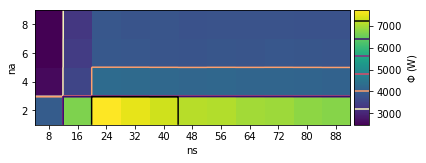

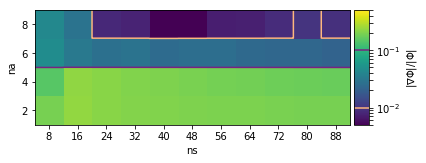

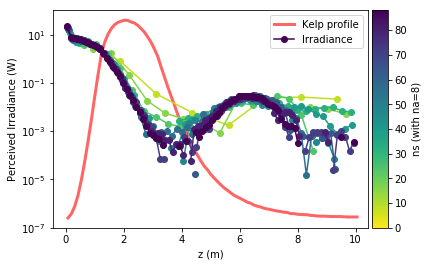

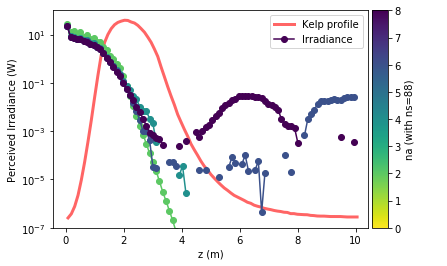

In [207]:
study_name = 'gs88_a01_b0_new'
ns_grid, na_grid, flux_grid, flux_grad_norm = cori_get_grid_study_flux(study_name)
plot_gs_convergence(ns_grid, na_grid, flux_grid, flux_grad_norm)
cori_plot_grid_study_irradiances(study_name)

### No Scattering, High Absorption

/global/homes/o/oevans/local/miniconda3/envs/kelp/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in less_equal


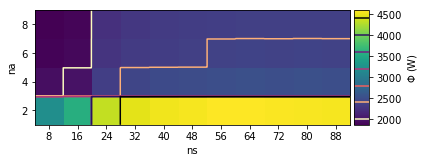

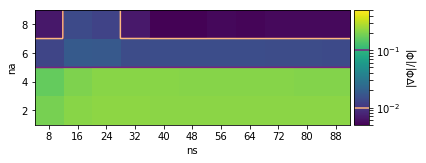

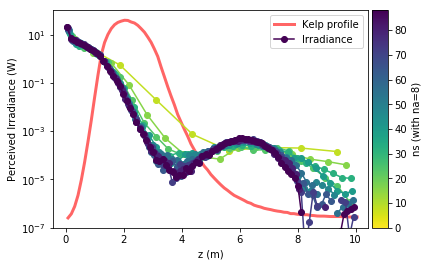

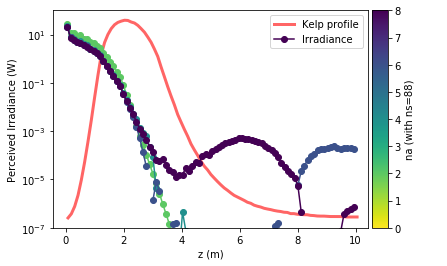

In [199]:
study_name = 'gs88_a05_b0_new'
ns_grid, na_grid, flux_grid, flux_grad_norm = cori_get_grid_study_flux(study_name)
plot_gs_convergence(ns_grid, na_grid, flux_grid, flux_grad_norm)
cori_plot_grid_study_irradiances(study_name)

### No Scattering, Really High Absorption

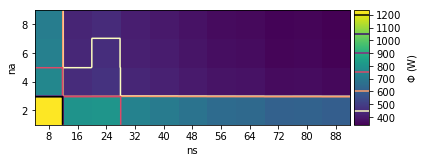

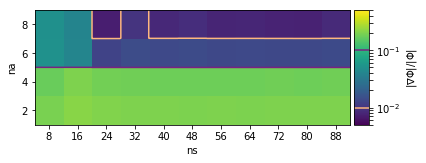

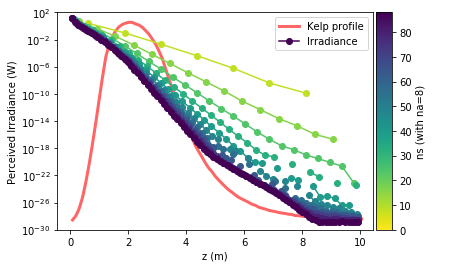

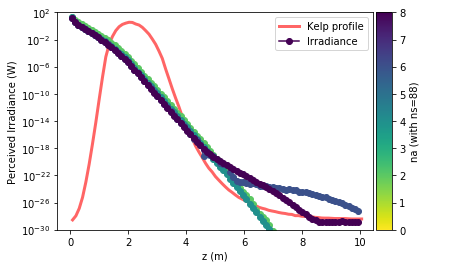

In [200]:
study_name = 'gs88_a50_b0_new'
ns_grid, na_grid, flux_grid, flux_grad_norm = cori_get_grid_study_flux(study_name)
plot_gs_convergence(ns_grid, na_grid, flux_grid, flux_grad_norm)
cori_plot_grid_study_irradiances(study_name, ylim=(1e-30,1e2))

## Low Scattering

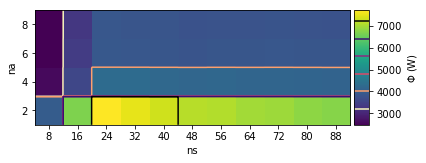

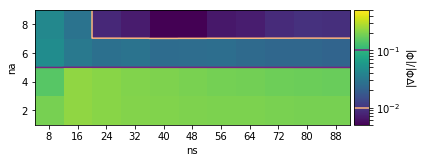

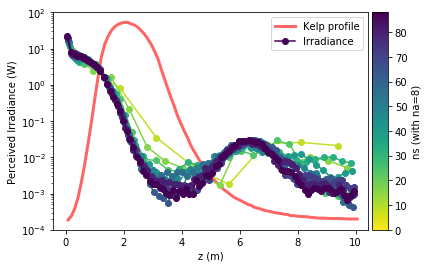

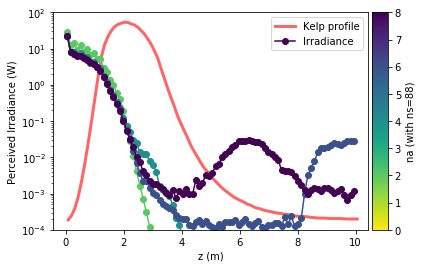

In [229]:
study_name = 'gs88_a01_b0_new'
ns_grid, na_grid, flux_grid, flux_grad_norm = cori_get_grid_study_flux(study_name)
plot_gs_convergence(ns_grid, na_grid, flux_grid, flux_grad_norm)
cori_plot_grid_study_irradiances(study_name, ylim=(1e-4,1e2))

## Middle Scattering

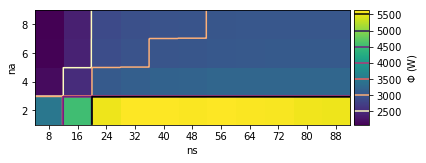

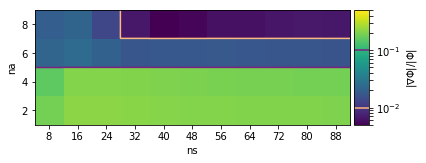

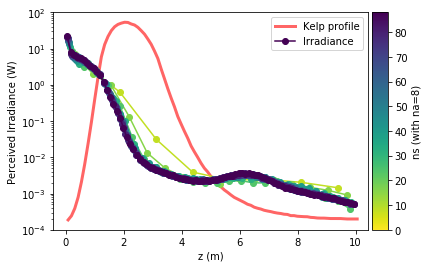

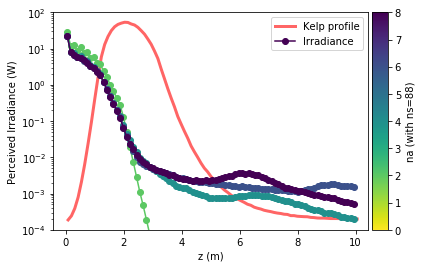

In [201]:
study_name = 'gs88_top_heavy_new'
ns_grid, na_grid, flux_grid, flux_grad_norm = cori_get_grid_study_flux(study_name)
plot_gs_convergence(ns_grid, na_grid, flux_grid, flux_grad_norm)
cori_plot_grid_study_irradiances(study_name, ylim=(1e-4,1e2))

## High Scattering

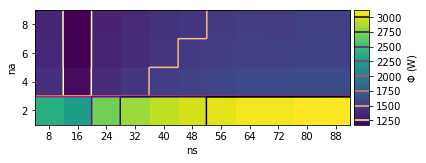

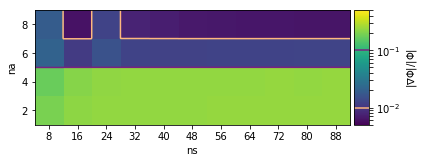

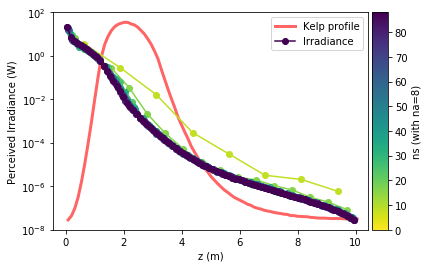

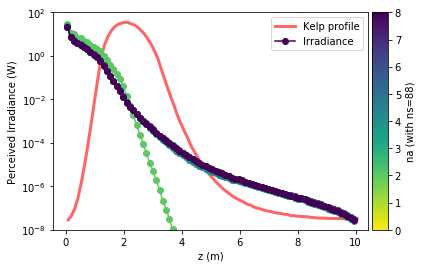

In [202]:
study_name = 'gs88_nuc2200_new'
ns_grid, na_grid, flux_grid, flux_grad_norm = cori_get_grid_study_flux(study_name)
plot_gs_convergence(ns_grid, na_grid, flux_grid, flux_grad_norm)
cori_plot_grid_study_irradiances(study_name, ylim=(1e-8,1e2))

## Bottom Heavy

/global/homes/o/oevans/local/miniconda3/envs/kelp/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in less_equal


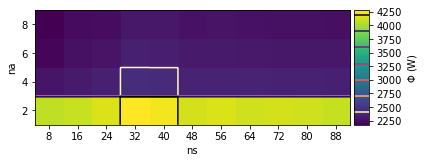

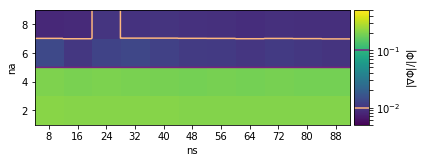

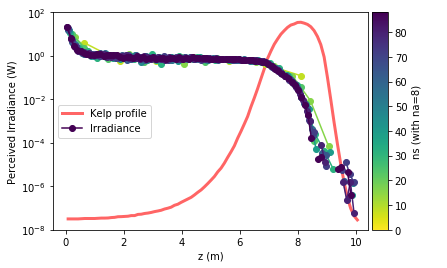

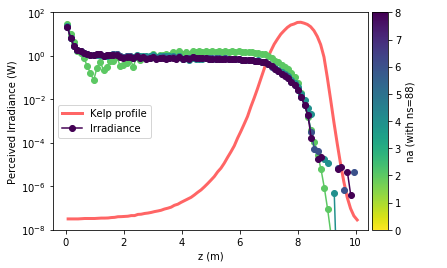

In [209]:
study_name = 'gs88_a01_b0_bh_new'
ns_grid, na_grid, flux_grid, flux_grad_norm = cori_get_grid_study_flux(study_name)
plot_gs_convergence(ns_grid, na_grid, flux_grid, flux_grad_norm)
cori_plot_grid_study_irradiances(study_name, ylim=(1e-8,1e2), legend_loc='center left')

## Too small

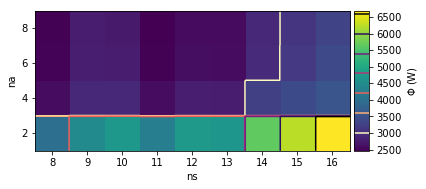

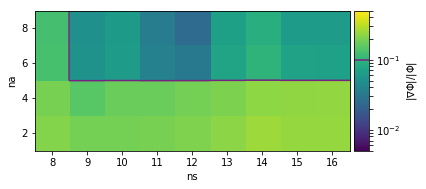

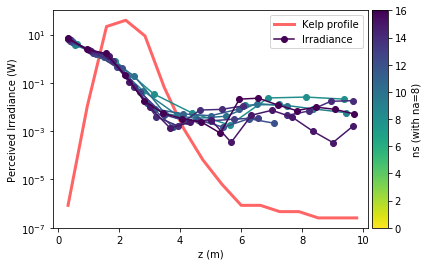

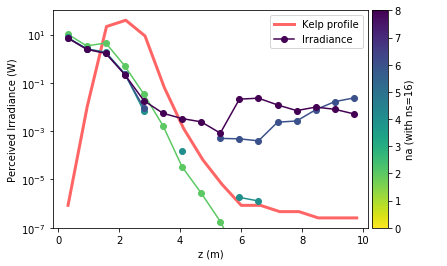

In [210]:
study_name = 'gs16_a01_b0_new'
ns_grid, na_grid, flux_grid, flux_grad_norm = cori_get_grid_study_flux(study_name)
plot_gs_convergence(ns_grid, na_grid, flux_grid, flux_grad_norm)
cori_plot_grid_study_irradiances(study_name, ylim=(1e-7,1e2))

### n=64 Top Heavy


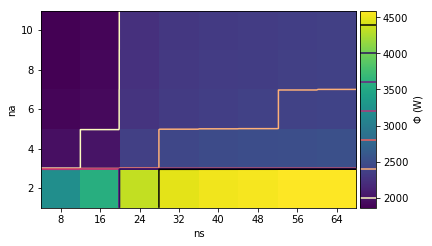

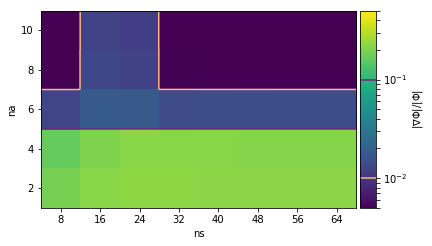

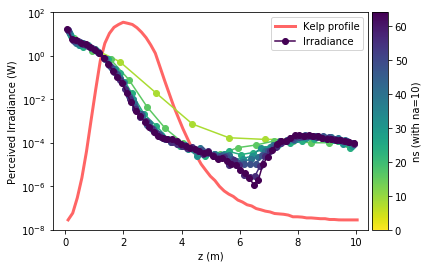

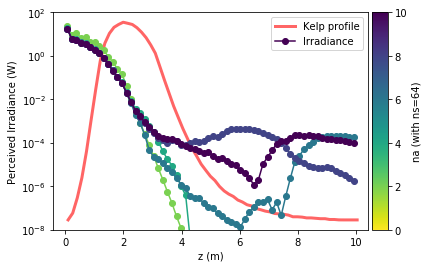

In [233]:
study_name = 'gs64_a05_b0_new'
ns_grid, na_grid, flux_grid, flux_grad_norm = cori_get_grid_study_flux(study_name)
plot_gs_convergence(ns_grid, na_grid, flux_grid, flux_grad_norm)
cori_plot_grid_study_irradiances(study_name, ylim=(1e-8,1e2))

# General

## Compare Two

abs_err = 6.646e-02
rel_err = 1.160e-01


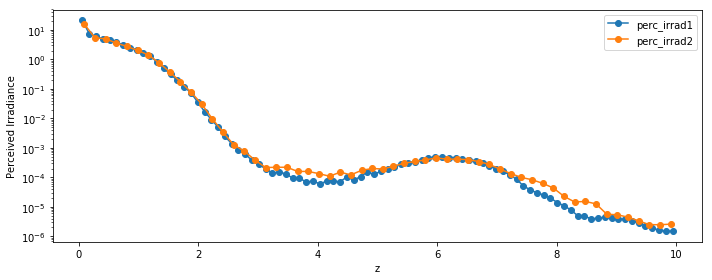

In [218]:
kelp_analyze.cori_plot_two_avg_irrads_onespace(
    'gs88_a05_b0_new',
    {'ns': 88, 'na': 8, 'fd_flag': True},
    {'ns': 56, 'na': 8, 'fd_flag': True},
    log_data=True
)
#plt.ylim(1e-7, 1e2)
#plt.xlim(0,3)

In [219]:
ipv.quickvolshow(results['p_kelp'][:])

/global/u2/o/oevans/python/packages/ipyvolume/ipyvolume/serialize.py:66: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0]**2 + gradient[1]**2 + gradient[2]**2)


In [220]:
ipv.quickvolshow(results['irrad'][:])

/global/homes/o/oevans/local/miniconda3/envs/kelp/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


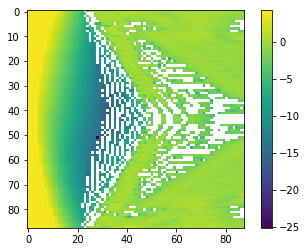

In [221]:
plt.imshow(np.log(results['irrad'][:][:,22,:]))
plt.colorbar()

In [216]:
ipv.quickvolshow(results['rad'][:][:,:,:,0])

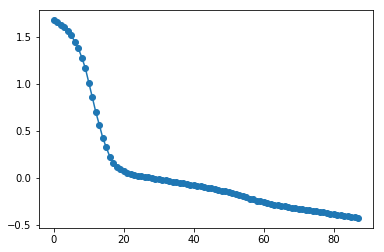

In [217]:
plt.plot(np.log10(np.mean(results['irrad'][:], axis=(0,1))), 'o-')